<a href="https://colab.research.google.com/github/ReL001/Assignment-1/blob/main/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/student/W1D3_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/student/W1D3_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/student/W1D3_Tutorial1.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 1: Generalization and representational geometry

**Week 1, Day 3: Comparing artificial and biological neural networks**

**By Neuromatch Academy**

__Content creators:__ JohnMark Taylor & Zhuofan Josh Ying

__Content reviewers:__ Samuele Bolotta, Yizhou Chen, RyeongKyung Yoon, Ruiyi Zhang, Lily Chamakura, Patrick Mineault, Hlib Solodzhuk, Alex Murphy

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk, Patrick Mineault, Alex Murphy


___


# Tutorial Objectives

*Estimated timing of tutorial: 40 minutes*

Welcome to Tutorial 1 on Generalization and Representational Geometry. Building on the Intro Lecture, this tutorial aims to help you get your feet wet and characterize representations in terms of their geometry, as captured by the distances among inputs at different stages of processing. **The key point of this tutorial is that the way machine learning models generalize depends on how they represent their inputs and, in particular, on how similar a new input is to other inputs in the internal representations**. We focus on linear models, where the close relationship between similarity and generalization can be most easily understood from an intuitive and mathematical perspective.

By the end of this tutorial, you will:

- Understand the concept of representational geometry and the representational dissimilarity matrix.
- Understand the connection between generalization and representational similarity in the linear case.
- Understand how the analytic solution for linear regression can be seen as a weighted sum of training values, weighted by the test inputs' similarity to the training inputs.

Exercises include:

1.   Question on comparing RDMs.
2.   Question on the relationship between RDMs and model performances.
3.   Interactive exercise on how similarity structure affects predictions.

This tutorial includes an interactive widget that plays only **locally or in Colab**, but **not in Kaggle**.

In [1]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
from ipywidgets import widgets
out = widgets.Output()

link_id = "uwn2g"

with out:
    print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
    display(IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=730, height=410))
display(out)

Output()

---
# Setup (Please Read)

This tutorial involves an interactive component as the final element, which depends on some tools that have undergone a change since the last time this course was run (2024). Therefore, if you're running this on Google Colab, you need to:

* uncomment the cell below
* run the cell

This will initially cause the notebook to restart after a few moments, but then you can run all the cells **below** (in Google Colab: *Runtime -> Run Cell and Below*) as necessary and the intended functionally will exist. As of the time of writing, this issue has not been corrected and this workaround is required. Please wait until you see the notification of the notebook having restarted before selecting the 'Run all and below' menu option.

Additionally, this tutorial uses `Graphviz` for additional visualizations. For proper execution of the functions, you should install it locally. Please visit this [link](https://graphviz.org/download/) to get the instructions depending on your local OS configurations (if you are running this notebook on Google Colab, just skip it).

In [2]:
!pip install -q ipympl
get_ipython().kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

In [2]:
# @title Install dependencies

!pip install -q ipympl ipywidgets mpl_interactions["jupyter"] torchlens
!pip install -q graphviz
!pip install rsatoolbox==0.1.5

# To install jupyter-matplotlib (ipympl) via pip
!pip install -q torchlens
!pip install -q numpy scikit-learn torch torchvision scipy matplotlib

# Import future dependencies first
from __future__ import print_function

# Configure matplotlib ONCE before any other matplotlib imports
import matplotlib
%matplotlib inline

# Now import pyplot AFTER setting the backend
import matplotlib.pyplot as plt

# Configure other matplotlib settings
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")


# To install jupyter-matplotlib via conda (comment out if you are not using conda)
# !conda install -c conda-forge ipympl

# To install the JupyterLab extension for ipywidgets
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager

# To install the JupyterLab extension for jupyter-matplotlib
# !jupyter labextension install jupyter-matplotlib

In [3]:
# @title Install and import feedback gadget

!pip install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_neuroai",
            "user_key": "wb2cxze8",
        },
    ).render()

feedback_prefix = "W1D3_T1"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [4]:
# @title Import dependencies

# Import future dependencies
from __future__ import print_function

# Standard library imports
import argparse
import warnings
import logging
from collections import OrderedDict

# Third-party library imports
import numpy as np
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from scipy import stats
import ipywidgets as widgets

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms, datasets
import torchlens as tl
from torchvision.utils import make_grid

# scikit-learn imports
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import linear_kernel

# rsatoolbox imports
import rsatoolbox
from rsatoolbox.data import Dataset
from rsatoolbox.rdm.calc import calc_rdm

In [5]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [6]:
# @title Plotting functions

def sample_images(data_loader, n=5, plot=False):
    """
    Samples a specified number of images from a data loader.

    Inputs:
    - data_loader (torch.utils.data.DataLoader): Data loader containing images and labels.
    - n (int): Number of images to sample per class.
    - plot (bool): Whether to plot the sampled images using matplotlib.

    Outpus:
    - imgs (torch.Tensor): Sampled images.
    - labels (torch.Tensor): Corresponding labels for the sampled images.
    """
    with plt.xkcd():

        imgs, labels = next(iter(data_loader))

        imgs_o = []
        targets = []
        for value in range(10):
            imgs_o.append(imgs[np.where(labels == value)][0:n])
            targets.append([value]*5)

        imgs = torch.cat(imgs_o, dim=0)
        targets = torch.tensor(targets).flatten()

        if plot:
            plt.imshow(torch.moveaxis(make_grid(imgs, nrow=5, padding=0, normalize=False, pad_value=0), 0,-1))
            plt.axis('off')

    return imgs, targets


def plot_maps(model_features, model_name):
    """
    Plots representational dissimilarity matrices (RDMs) across different layers of a model.

    Inputs:
    - model_features (dict): a dictionary where keys are layer names and values are numpy arrays representing RDMs for each layer.
    - model_name (str): the name of the model being visualized.
    """
    with plt.xkcd():

        fig = plt.figure(figsize=(14, 4))
        fig.suptitle(f"RDMs across layers for {model_name}")
        # and we add one plot per reference point
        gs = fig.add_gridspec(1, len(model_features))
        fig.subplots_adjust(wspace=0.2, hspace=0.2)

        for l in range(len(model_features)):

            layer = list(model_features.keys())[l]
            map_ = np.squeeze(model_features[layer])

            if len(map_.shape) < 2:
                map_ = map_.reshape( (int(np.sqrt(map_.shape[0])), int(np.sqrt(map_.shape[0]))) )

            map_ = map_ / np.max(map_)

            ax = plt.subplot(gs[0,l])
            ax_ = ax.imshow(map_, cmap='magma_r')
            ax.set_title(f'{layer}')
            ax.set_xlabel("input index")
            if l==0:
              ax.set_ylabel("input index")

        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([1.01, 0.18, 0.01, 0.53])
        cbar = fig.colorbar(ax_, cax=cbar_ax)
        cbar.set_label('Dissimilarity', rotation=270, labelpad=15)

        plt.show()

In [7]:
# @title Helper functions

import contextlib
import io

def train_one_epoch(args, model, device, train_loader, optimizer, epoch):
    """
    Trains the model for one epoch.

    Inputs:
    - args (Namespace): Arguments for training configuration.
    - model (torch.nn.Module): The model to be trained.
    - device (torch.device): The device to use for training (CPU/GPU).
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training data.
    - optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
    - epoch (int): The current epoch number.
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

def test(model, device, test_loader, return_features=False):
    """
    Evaluates the model on the test dataset.

    Inputs:
    - model (torch.nn.Module): The model to be evaluated.
    - device (torch.device): The device to use for evaluation (CPU/GPU).
    - test_loader (torch.utils.data.DataLoader): DataLoader for the test data.
    - return_features (bool): If True, returns the features from the model. Default is False.
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def build_args():
    """
    Builds and parses command-line arguments for training.
    """
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=2, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=50, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args('')

    use_cuda = torch.cuda.is_available() #not args.no_cuda and
    use_mps = not args.no_mps and torch.backends.mps.is_available()

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    args.use_cuda = use_cuda
    args.device = device
    return args

def fetch_dataloaders(args):
    """
    Fetches the data loaders for training and testing datasets.

    Inputs:
    - args (Namespace): Parsed arguments with training configuration.

    Outputs:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training data.
    - test_loader (torch.utils.data.DataLoader): DataLoader for the test data.
    """
    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if args.use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    with contextlib.redirect_stdout(io.StringIO()): #to suppress output
        dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
        dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
        train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
        test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
        return train_loader, test_loader

def train_model(args, model, optimizer):
    """
    Trains the model using the specified arguments and optimizer.

    Inputs:
    - args (Namespace): Parsed arguments with training configuration.
    - model (torch.nn.Module): The model to be trained.
    - optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.

    Outputs:
    - None: The function trains the model and optionally saves it.
    """
    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train_one_epoch(args, model, args.device, train_loader, optimizer, epoch)
        test(model, args.device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")

def train_one_epoch_adversarial(args, model, device, train_loader, optimizer, epoch):
    """
    Trains the model for one epoch using adversarial examples.

    Inputs:
    - args (Namespace): Arguments for training configuration.
    - model (torch.nn.Module): The model to be trained.
    - device (torch.device): The device to use for training (CPU/GPU).
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training data.
    - optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
    - epoch (int): The current epoch number.

    Outputs:
    - None: The function prints the training progress and loss.
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # train the model on adversarial images
        epsilon = 0.2
        data = generate_adversarial(model, data, target, epsilon)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

def train_model_adversarial(args, model, optimizer):
    """
    Trains the model using adversarial training.

    Inputs:
    - args (Namespace): Parsed arguments with training configuration.
    - model (torch.nn.Module): The model to be trained.
    - optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.

    Outputs:
    - None: The function trains the model using adversarial examples and optionally saves it.
    """
    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train_one_epoch_adversarial(args, model, args.device, train_loader, optimizer, epoch)
        test(model, args.device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "robust_mnist_cnn.pt")

def calc_rdms(model_features, method='correlation'):
    """
    Calculates representational dissimilarity matrices (RDMs) for model features.

    Inputs:
    - model_features (dict): A dictionary where keys are layer names and values are features of the layers.
    - method (str): The method to calculate RDMs, e.g., 'correlation'. Default is 'correlation'.

    Outputs:
    - rdms (pyrsa.rdm.RDMs): RDMs object containing dissimilarity matrices.
    - rdms_dict (dict): A dictionary with layer names as keys and their corresponding RDMs as values.
    """
    ds_list = []
    for l in range(len(model_features)):
        layer = list(model_features.keys())[l]
        feats = model_features[layer]

        if type(feats) is list:
            feats = feats[-1]

        feats = feats.cpu()

        if len(feats.shape) > 2:
            feats = feats.flatten(1)

        feats = feats.detach().numpy()
        ds = Dataset(feats, descriptors=dict(layer=layer))
        ds_list.append(ds)

    rdms = calc_rdm(ds_list, method=method)
    rdms_dict = {list(model_features.keys())[i]: rdms.get_matrices()[i] for i in range(len(model_features))}

    return rdms, rdms_dict

def fgsm_attack(image, epsilon, data_grad):
    """
    Performs FGSM attack on an image.

    Inputs:
    - image (torch.Tensor): Original image.
    - epsilon (float): Perturbation magnitude.
    - data_grad (torch.Tensor): Gradient of the data.

    Outputs:
    - perturbed_image (torch.Tensor): Perturbed image after FGSM attack.
    """
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Converts a batch of normalized tensors to their original scale.

    Inputs:
    - batch (torch.Tensor): Batch of normalized tensors.
    - mean (torch.Tensor or list): Mean used for normalization.
    - std (torch.Tensor or list): Standard deviation used for normalization.

    Outputs:
    - torch.Tensor: Batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(batch.device)
    if isinstance(std, list):
        std = torch.tensor(std).to(batch.device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

def generate_adversarial(model, imgs, targets, epsilon):
    """
    Generates adversarial examples using FGSM attack.

    Inputs:
    - model (torch.nn.Module): The model to attack.
    - imgs (torch.Tensor): Batch of images.
    - targets (torch.Tensor): Batch of target labels.
    - epsilon (float): Perturbation magnitude.

    Outputs:
    - adv_imgs (torch.Tensor): Batch of adversarial images.
    """
    adv_imgs = []

    for img, target in zip(imgs, targets):
        img = img.unsqueeze(0)
        target = target.unsqueeze(0)
        img.requires_grad = True

        output = model(img)
        loss = F.nll_loss(output, target)

        model.zero_grad()
        loss.backward()

        data_grad = img.grad.data
        data_denorm = denorm(img)
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        adv_imgs.append(perturbed_data_normalized.detach())

    return torch.cat(adv_imgs)

def test_adversarial(model, imgs, targets):
    """
    Tests the model on adversarial examples and prints the accuracy.

    Inputs:
    - model (torch.nn.Module): The model to be tested.
    - imgs (torch.Tensor): Batch of adversarial images.
    - targets (torch.Tensor): Batch of target labels.
    """
    correct = 0
    output = model(imgs)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(targets.view_as(pred)).sum().item()

    final_acc = correct / float(len(imgs))
    print(f"adversarial test accuracy = {correct} / {len(imgs)} = {final_acc}")

def extract_features(model, imgs, return_layers, plot='none'):
    """
    Extracts features from specified layers of the model.

    Inputs:
    - model (torch.nn.Module): The model from which to extract features.
    - imgs (torch.Tensor): Batch of input images.
    - return_layers (list): List of layer names from which to extract features.
    - plot (str): Option to plot the features. Default is 'none'.

    Outputs:
    - model_features (dict): A dictionary with layer names as keys and extracted features as values.
    """
    model_history = tl.log_forward_pass(model, imgs, layers_to_save='all', vis_opt=plot)
    model_features = {}
    for layer in return_layers:
        model_features[layer] = model_history[layer].tensor_contents.flatten(1)

    return model_features

In [8]:
# @title Data retrieval

import os
import requests
import hashlib

# Variables for file and download URL
fnames = ["standard_model.pth", "adversarial_model.pth"] # The names of the files to be downloaded
urls = ["https://osf.io/s5rt6/download", "https://osf.io/qv5eb/download"] # URLs from where the files will be downloaded
expected_md5s = ["2e63c2cd77bc9f1fa67673d956ec910d", "25fb34497377921b54368317f68a7aa7"] # MD5 hashes for verifying files integrity

for fname, url, expected_md5 in zip(fnames, urls, expected_md5s):
    if not os.path.isfile(fname):
        try:
            # Attempt to download the file
            r = requests.get(url) # Make a GET request to the specified URL
        except requests.ConnectionError:
            # Handle connection errors during the download
            print("!!! Failed to download data !!!")
        else:
            # No connection errors, proceed to check the response
            if r.status_code != requests.codes.ok:
                # Check if the HTTP response status code indicates a successful download
                print("!!! Failed to download data !!!")
            elif hashlib.md5(r.content).hexdigest() != expected_md5:
                # Verify the integrity of the downloaded file using MD5 checksum
                print("!!! Data download appears corrupted !!!")
            else:
                # If download is successful and data is not corrupted, save the file
                with open(fname, "wb") as fid:
                    fid.write(r.content) # Write the downloaded content to a file

In [9]:
# @title Set random seed

import random
import numpy as np
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(seed = 42)

In [10]:
# @title Set device (GPU or CPU)

def set_device():
    """
    Determines and sets the computational device for PyTorch operations based on the availability of a CUDA-capable GPU.

    Outputs:
    - device (str): The device that PyTorch will use for computations ('cuda' or 'cpu'). This string can be directly used
    in PyTorch operations to specify the device.
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("GPU is not enabled in this notebook. \n"
              "If you want to enable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `GPU` from the dropdown menu")
    else:
        print("GPU is enabled in this notebook. \n"
              "If you want to disable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `None` from the dropdown menu")

    return device

device = set_device()

GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu


In [ ]:
# @title Video 1: Tutorial Introduction

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'ppW9BmOr790'), ('Bilibili', 'BV1pf421Q7vA')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_tutorial_introduction")

---
# Section 1: MNIST DNN Comparisons

In this section, we are going to take a look at the MNIST Dataset and its adversarial version.

In this activity, you will use linear regression on representations of two neural networks trained on MNIST, one with adversarial training and one without. The objective is to observe:

- How predictions for clean images of numbers are similar between networks for a deep layer
- The close alignment of the predictions with the category structure
- How the dissimilarity matrix reflects a category structure
- How dissimilarity matrices from the two networks compare
- The significant differences in predictions and dissimilarity matrices when applying adversarial examples

## Understanding the MNIST DNNs

We start by defining two models on the MNIST dataset: a standard model and an adversarially robust model. The training process for the adversarially robust model includes a step where adversarial examples are generated and used to train the robust model.

You are already provided with the trained models to save time. Still, you are free to explore the training code being included in the tutorial.

### Defining the MNIST Model

First, we define a neural network model that will be trained on the MNIST dataset. The MNIST dataset consists of 28x28 pixel images of handwritten digits (0 through 9). Our model, based on the LeNet architecture, includes two convolutional layers followed by dropout layers to reduce overfitting and, finally, fully connected layers to perform classification.

In [11]:
# @title MNIST Model

# modified and reorganized from https://github.com/pytorch/examples/blob/main/mnist/main.py

#lenet model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

## Training the Standard Model

Once the model is defined, we would normally proceed to train it on the MNIST dataset. Training involves feeding batches of images and their corresponding labels to the model and adjusting the model's weights based on the loss computed from its predictions and the actual labels through backpropagation and gradient descent. This process is iterated over multiple epochs to improve the model's accuracy.

The training code is copied here for reference in a commented block. We ran this code offline and saved a checkpoint. In the interest of time, we'll skip ahead to loading this checkpoint into the model.

In [12]:
# @title Build and train the model

# args = build_args()
# torch.manual_seed(args.seed)
# train_loader, test_loader = fetch_dataloaders(args)

# # build_model
# model = Net().to(args.device)

# print(model)
# optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# # train model
# train_model(args, model, optimizer) #train the model for 2 epochs ~ %99 accuracy ~ 30 sec colab gpu

# torch.save(model, "standard_model.pth")

In [13]:
# @title Grab a pretrained model

args = build_args()
train_loader, test_loader = fetch_dataloaders(args)
path = "standard_model.pth"
model = torch.load(path, map_location=args.device, weights_only=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.45MB/s]


## Adversarial Attack & Model Robustness

**Generating Adversarial Examples**

Adversarial examples are inputs to machine learning models that an attacker has intentionally designed to cause the model to make a mistake. They are often **indistinguishable** from real data by humans but result in incorrect predictions by the model. Generating these examples and using them in training can improve a model's robustness against such attacks.

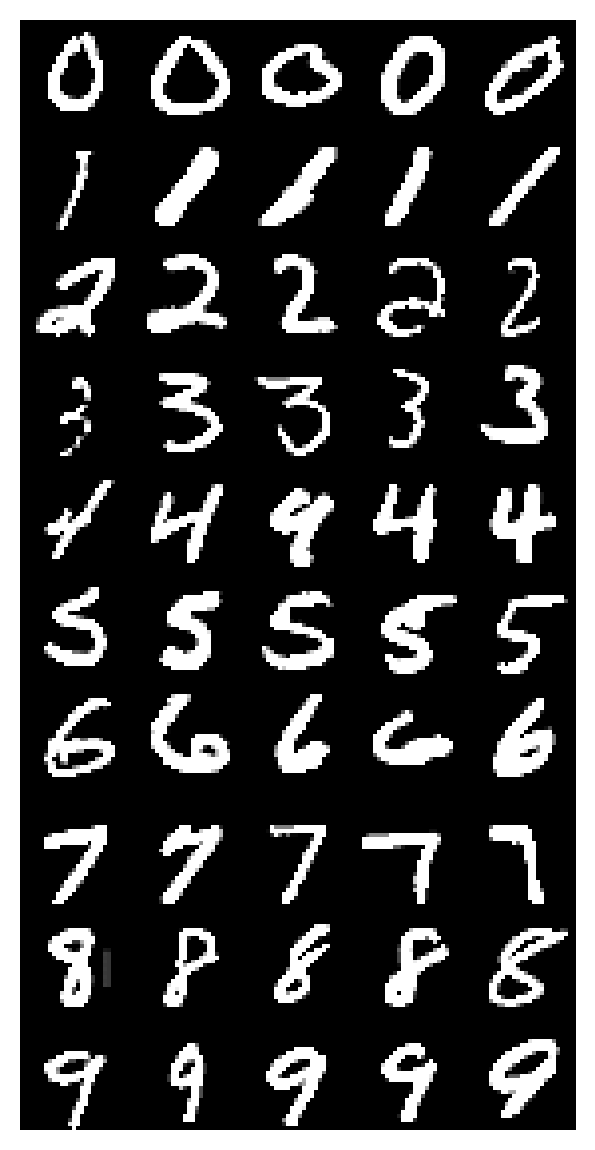

In [14]:
# @title Grab 5 test images from each category and visualize them
imgs, targets = sample_images(test_loader, n=5, plot = True)

Here, we generate adversarial images using the Fast Gradient Sign Method (FGSM). This is a popular and straightforward adversarial attack technique designed to test the robustness of neural networks. Developed by Ian Goodfellow and his colleagues in 2014, FGSM backprops through the neural network to create perturbed inputs that maximize the loss:

$$\text{perturbed image} = \text{image} + \epsilon \cdot \text{sign}(\nabla_{\text{image}} J(\text{image}, \text{true label}))$$

where:

* $\text{perturbed image}$ is the adversarial image
* $\text{image}$ is the original input image
* $\epsilon$ is the magnitude of the perturbation
* $\nabla_{\text{image}} J(\text{image}, \text{true label})$ is the gradient of the loss with respect to the input image
* $\text{sign}(\cdot)$ returns the sign of the argument (either `1` or `-1`)

(np.float64(-0.5), np.float64(139.5), np.float64(279.5), np.float64(-0.5))

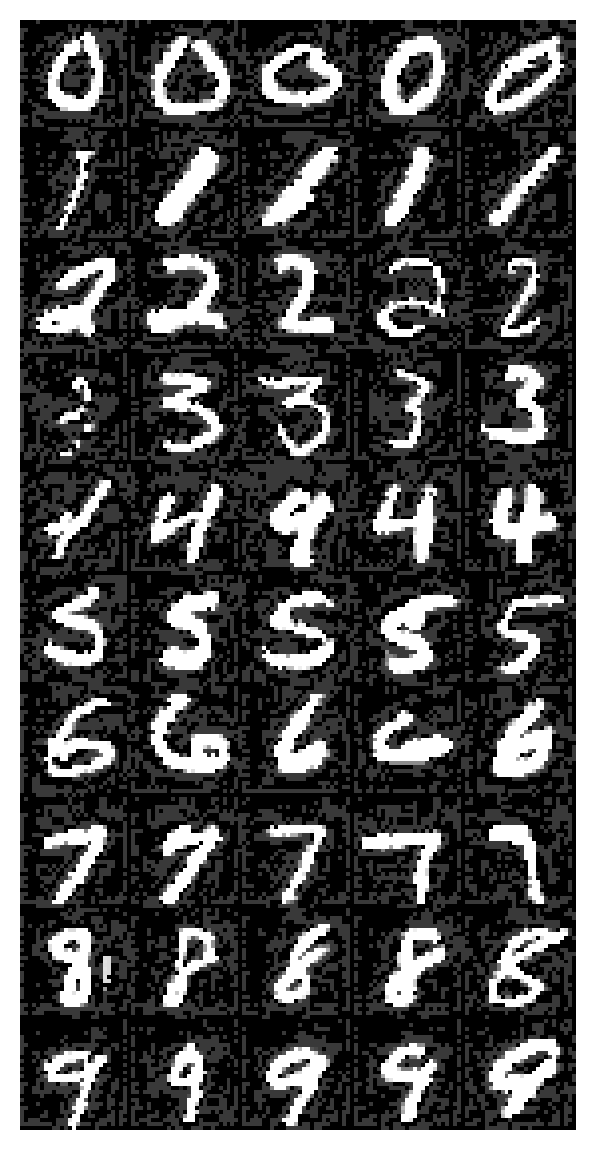

In [15]:
# @title Generate adversarial images for the standard model

set_seed(42)

eps = 0.2
imgs =imgs.to(args.device)
targets = targets.to(args.device)

adv_imgs = generate_adversarial(model, imgs, targets, eps)

plt.imshow(torch.moveaxis(make_grid(adv_imgs.cpu(), nrow=5, padding=0, normalize=False, pad_value=0), 0,-1))
plt.axis('off')

As you can see, the black background from the **clean** and original images has changed a bit to include intricate patterns that do not affect our interpretation of what digit is being represented overall (because humans focus on the white pixels that make up the MNIST digit). However, this new fluctuating pattern in the background of each image will demonstrate that the models can be tricked into **perceiving** different digits based on this background pattern. This is the issue we want to solve when training an *adversarially robust* model.

## Training the Adversarially Robust Model

With adversarial examples at hand, we now train a model designed to be robust against such examples. The idea is to include adversarial examples in the training process, enabling the model to learn from and defend against them.

Again, we've included the training code in a commented section, and you are presented with an already adversarially trained network.

In [16]:
# @title Train adversirally robust model

# model_robust = Net().to(args.device)
# optimizer = optim.Adadelta(model_robust.parameters(), lr=args.lr)
# train_model_adversarial(args, model_robust, optimizer) #train the model for 2 epochs ~ %98 accuracy ~ 2 minutes on cpu
# torch.save(model_robust, "adversarial_model.pth")

In [17]:
# @title Grab an adversarially pretrained model

path = "adversarial_model.pth"
model_robust = torch.load(path, map_location=args.device, weights_only=False)

(np.float64(-0.5), np.float64(139.5), np.float64(279.5), np.float64(-0.5))

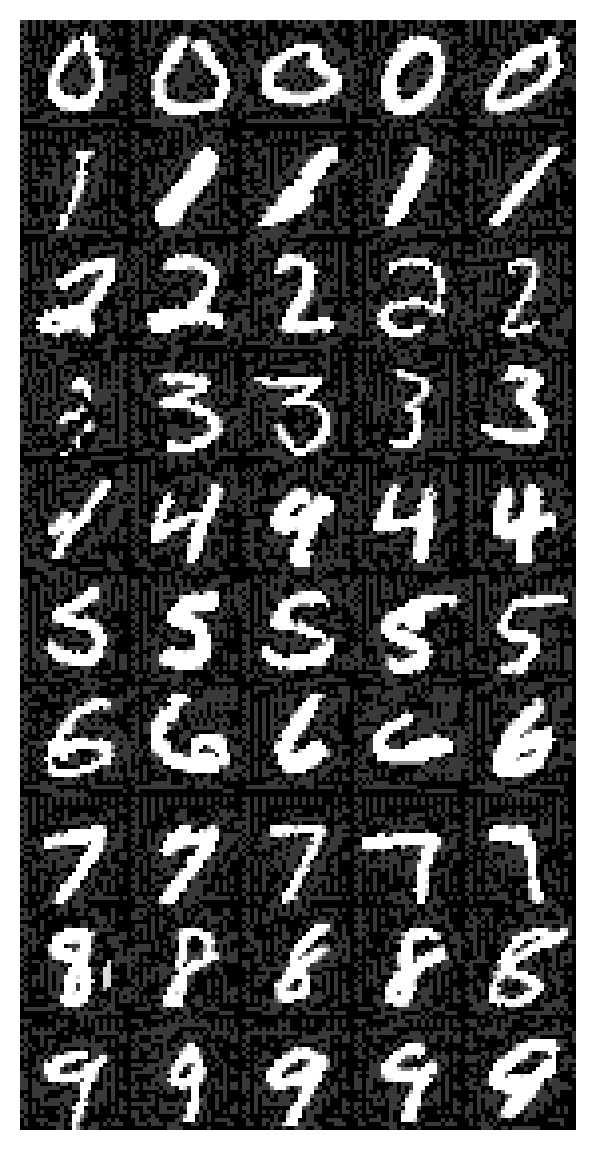

In [18]:
# @title Generate adversarial images for the adversarially trained model

set_seed(42)

eps = 0.2
imgs =imgs.to(args.device)
targets = targets.to(args.device)

adv_imgs_advmodel = generate_adversarial(model_robust, imgs, targets, eps)

plt.imshow(torch.moveaxis(make_grid(adv_imgs_advmodel.cpu(), nrow=5, padding=0, normalize=False, pad_value=0), 0,-1))
plt.axis('off')

## Evaluating Model Robustness

Now that we have a trained model, we evaluate its resistance to adversarial attacks. We do this by testing the models on both standard and adversarial images and comparing their accuracies.

While these adversarially generated images are visually indistinguishable from the original ones, they cause dramatic decreases in the standard model, while the adversarially trained model is robust to this kind of attack.

In [19]:
# @title Test model

# test adversarial robustness
print("For standard model trained without adversarial examples (eps=0.2):")
test_adversarial(model, adv_imgs, targets)
print("For adversrially trained model (eps=0.2):")
test_adversarial(model_robust, adv_imgs_advmodel, targets)

For standard model trained without adversarial examples (eps=0.2):
adversarial test accuracy = 27 / 50 = 0.54
For adversrially trained model (eps=0.2):
adversarial test accuracy = 47 / 50 = 0.94


You should observe that the adversarially trained model has much higher accuracy on the adversarial images (98%) than the standard model does (60%) on the same images.

## Extracting Model Features and Analyzing Representations

With the models trained and adversarial images generated, we proceed to extract features from different layers of our networks using [torchlens](https://github.com/johnmarktaylor91/torchlens), a package for extracting neural network activations and visualizing their computational graph.  This will allow us to peer into the data representations at different layers of the models in normal and adversarial conditions.

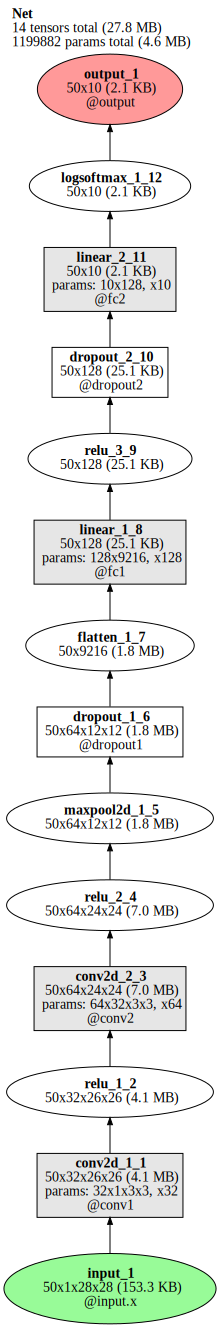

In [20]:
# @title Extract model features with torchlens

return_layers = ['input_1', 'conv1', 'conv2', 'fc1', 'fc2']
features_model_imgs = extract_features(model, imgs, return_layers, plot = 'rolled') #comment this line if Graphviz installation was unsuccessful for you

features_model_advimgs = extract_features(model, adv_imgs, return_layers)
features_advmodel_imgs = extract_features(model_robust, imgs, return_layers)
features_advmodel_advimgs = extract_features(model_robust, adv_imgs_advmodel, return_layers)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_mnist_dnn_comparison")

---
# Section 2: Creating and Comparing Representation Dissimilarity Matrices

*Estimated timing to here from start of tutorial: 15 minutes*

Using the Representational Similarity Analysis (RSA) toolbox, you will create representational dissimilarity matrices (RDMs) for each model and condition (standard and adversarial). These matrices provide a visual representation of how inputs are represented within the network, offering insights into the models' generalization capabilities and the effects of adversarial training.

## What is an RDM?

Before diving into the practical applications, let's clarify what an RDM is. An RDM is a tool used to measure and visualize the dissimilarities in the responses of a neural system to different inputs. It is represented as a matrix $M$ where each element $M_{ij}$ measures how dissimilar the response patterns in some layer of a neural network are to the $i$-th and $j$-th input. Let's consider a particular estimator of representational dissimilarity:

$$M_{ij} = 1 - r(x_i, x_j)$$

Here $r(x_i, x_j)$ is the Pearson correlation coefficient between the representations of the $i$-th and $j$-th inputs. $1 - r(x_i, x_j)$ is also known as the correlation distance, which quantifies the dissimilarity between two inputs.

RDMs help us understand how well a model differentiates between various types of inputs, which is a key aspect of generalization. They are particularly useful in deep learning as they help illustrate the level at which different layers of a network or different networks recognize and differentiate between input categories. A well-performing model will show clear patterns of dissimilarity corresponding to different input categories, especially in deeper layers.

## Visualizing RDMs

We first visualize the category structure by computing the RDM of the labels. To see clear blocks in RDMs—where blocks indicate that inputs of the same class are represented similarly—we need to ensure that input images are organized and grouped by their class labels before calculating the RDM. Here, we have 10 classes (numbers 0-9), each class with 5 samples, which sums up to 50 input images. Recall that each element of the RDM $M_{ij}$ refers to the dissimilarity between the representations of the $i$-th and $j$-th inputs. Make sure you understand the figure of RDM of the labels below.

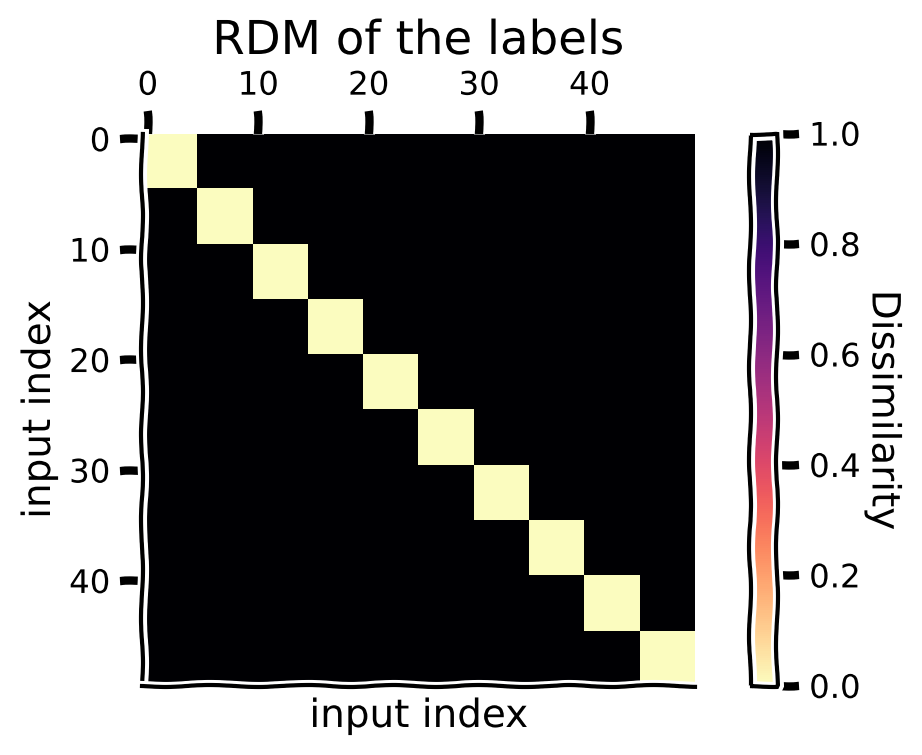

In [21]:
# @title RDMs for the labels (see the category structures)

one_hot_labels = {"labels": F.one_hot(targets, num_classes=10) }
rdms, rdms_dict = calc_rdms(one_hot_labels, method='euclidean')

# plot rdm
with plt.xkcd():
    plt.figure(figsize=(6, 4))
    plt.imshow(rdms_dict['labels']/rdms_dict['labels'].max(), cmap='magma_r')
    plt.title("RDM of the labels")
    plt.xlabel("input index")
    plt.ylabel("input index")
    cbar = plt.colorbar()
    cbar.set_label('Dissimilarity', rotation=270, labelpad=15)
    plt.show()

Is it clear to you that the block associated with indices 20-25 in the figure above represent similarity of the 5th class label (the digit '4')? If not, go back and re-read the paragraphs above and take care to relate the block structure to the 5 samples per image class.

Now we compute and visualize the RDMs for **standard images** for both the standard model and the adversarially trained model.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


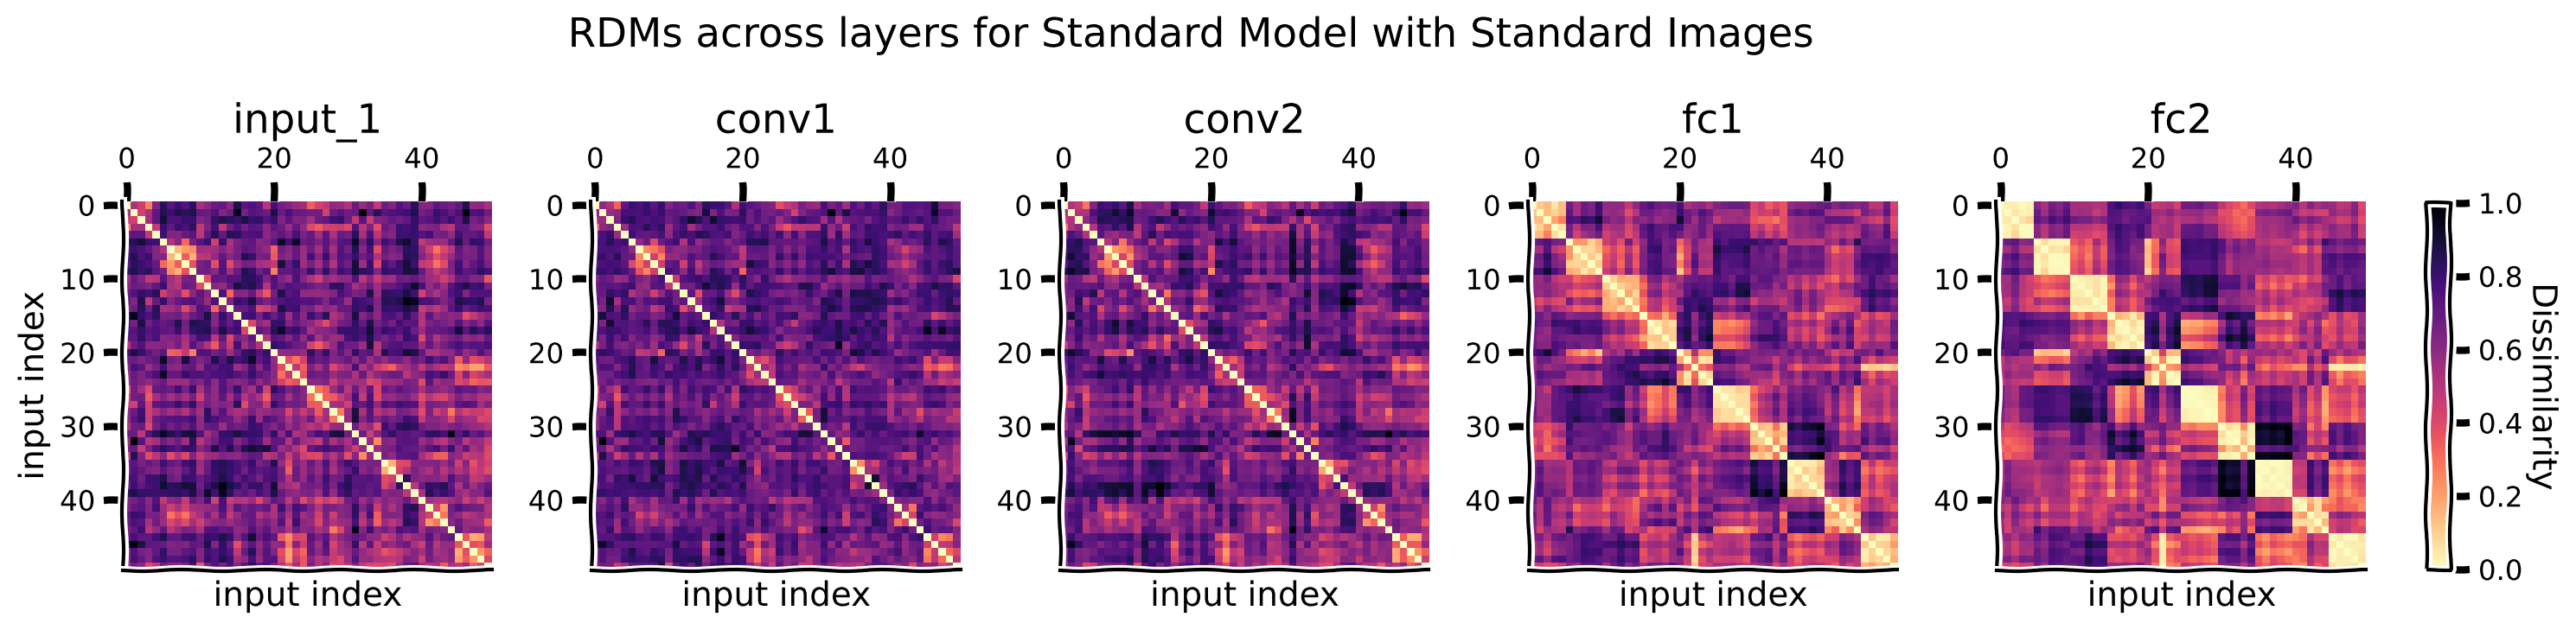

In [22]:
# @title For standard model + standard images
rdms, rdms_dict = calc_rdms(features_model_imgs)
plot_maps(rdms_dict, "Standard Model with Standard Images")

In [ ]:
# @title For adversarially trained model + standard images
rdms, rdms_dict = calc_rdms(features_advmodel_imgs)
plot_maps(rdms_dict, "Adversarial Trained Model with Standard Images")

### Think!

1. For the standard clean images, how do the RDMs change across the model layers, how do they compare to the category structure, and why?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/solutions/W1D3_Tutorial1_Solution_7a860365.py)



RDMs of the standard model and the adversarially trained model are very similar for clean images.

Now we compute and visualize the RDMs for **adversarial images** for both the standard model and the adversarially trained model.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


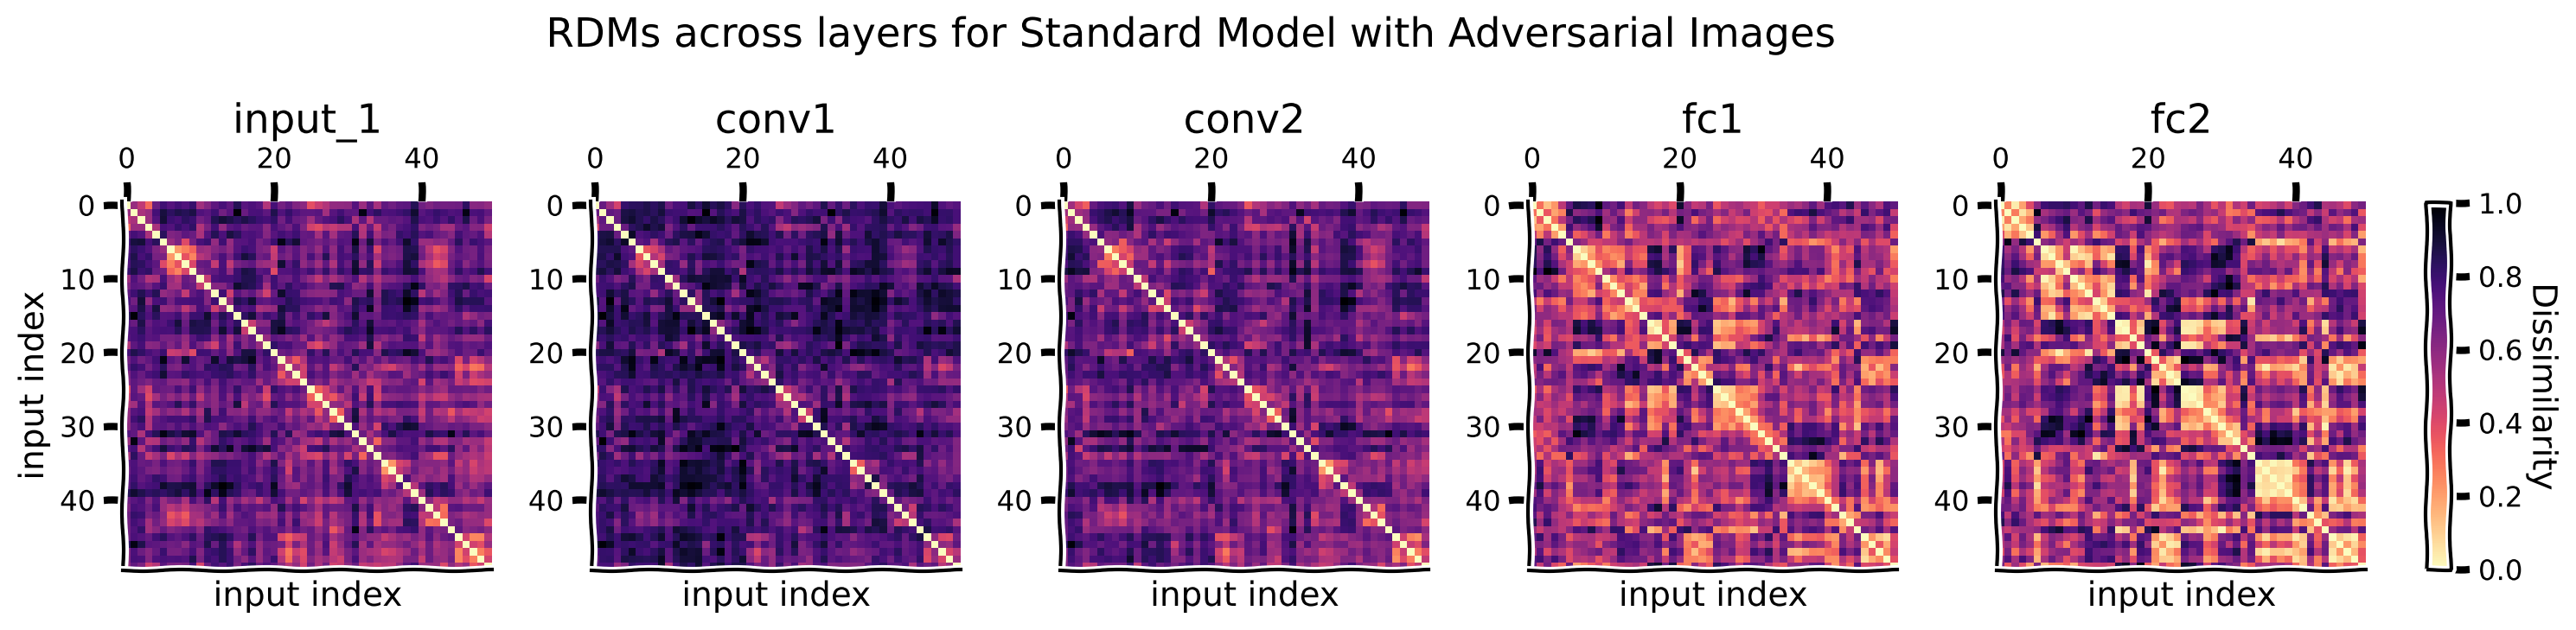

In [23]:
# @title For standard model + adversarial images
rdms, rdms_dict = calc_rdms(features_model_advimgs)
plot_maps(rdms_dict, "Standard Model with Adversarial Images")

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


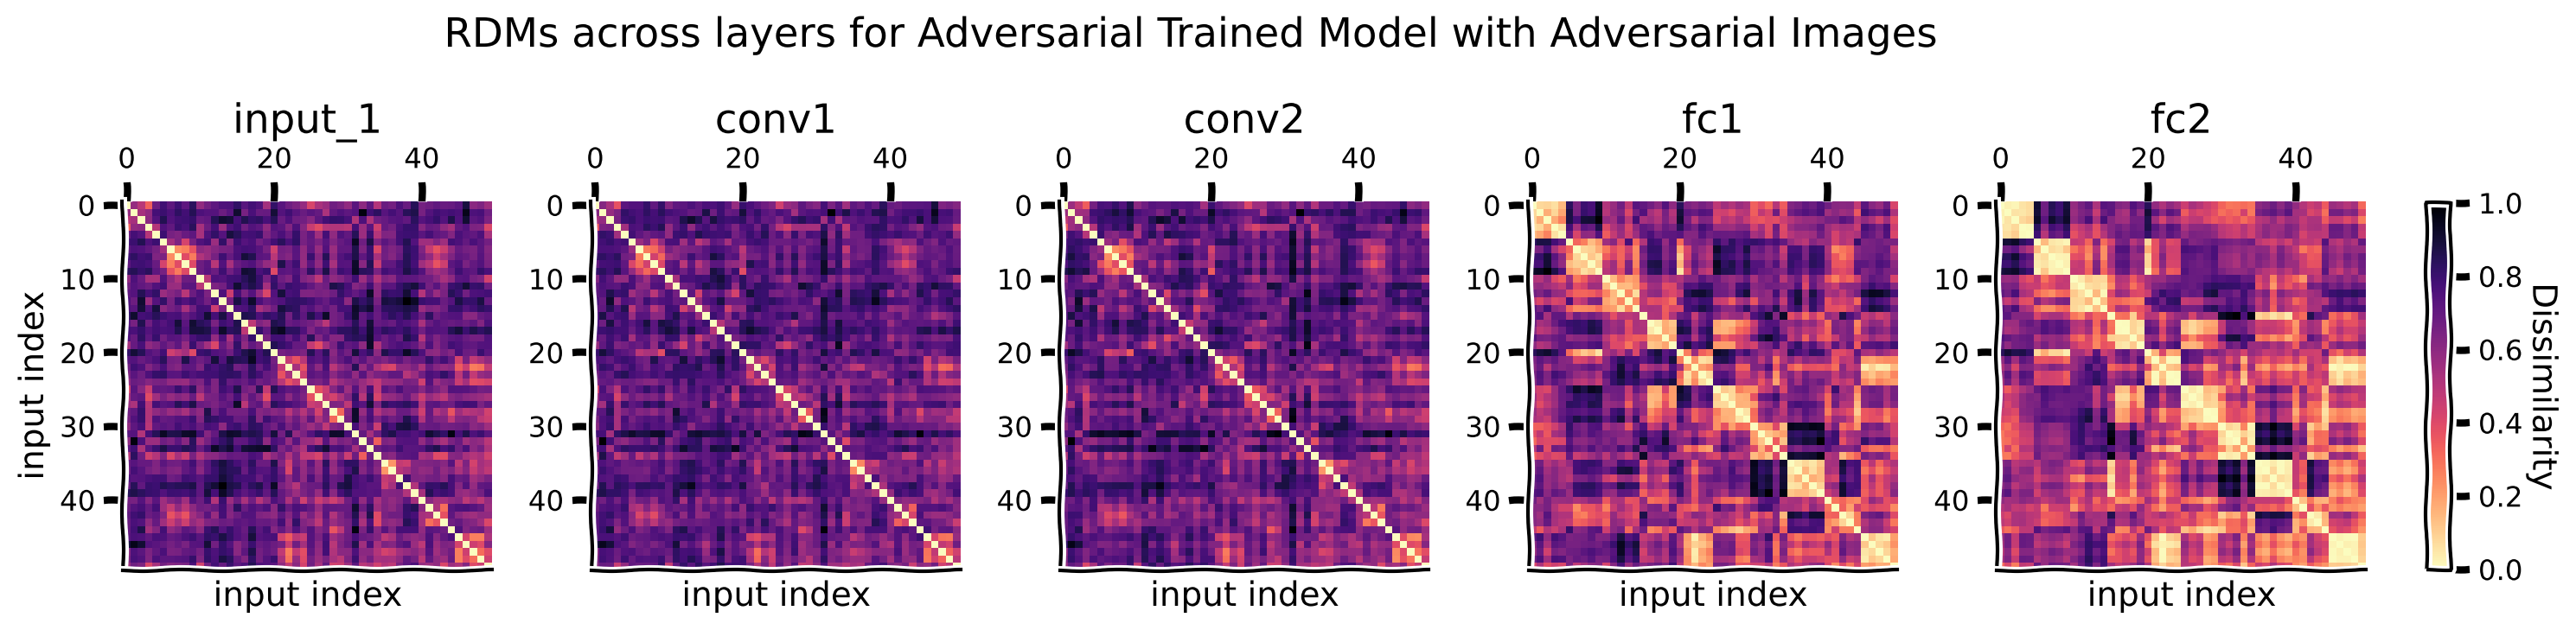

In [24]:
# @title For adversarially trained model + adversarial images
rdms, rdms_dict = calc_rdms(features_advmodel_advimgs)
plot_maps(rdms_dict, "Adversarial Trained Model with Adversarial Images")

### Think!

1. For adversarial images, how do the RDMs change when comparing representations from the standard model to the adversarially trained model?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/solutions/W1D3_Tutorial1_Solution_192afe09.py)



### Think!

1. How do the RDMs relate to the performances of the standard and the adversarially trained models on clean and adversarial images?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/solutions/W1D3_Tutorial1_Solution_dd06ba72.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_creating_comparing_rdms")

---
# Section 3: Interactive Exploration with Widgets

*Estimated timing to here from start of tutorial: 30 minutes*


In Sections 1 & 2, we saw that networks generalize better when their test stimuli are "similar" to their training stimuli: the network trained only on normal MNIST images generalized poorly to adversarially generated images since they were not part of its training diet, whereas the network trained with adversarial images generalized more effectively to new adversarial images. It turns out that we can sometimes be mathematically precise about how the similarity of training and test examples affects generalization performance. In this interactive example, you will explore the connection between similarity and generalization in the case of linear regression.

The manner in which a readout function generalizes to new inputs depends closely on the similarity of the new inputs to training stimuli--in other words, the more similar a test stimulus is to a training stimulus, the more similar the output of the readout will be. But what do we mean by "similar"? The relevant way to measure "similarity" in each case will depend on the readout function in question. In the case of linear regression, the relevant similarity metric is the kernel (dot product) similarity of the inputs. To see this, you can inspect the matrix form of the least squares solution for regression below:

$$y_{pred} = X_{pred} \left( X_{train}^T X_{train} \right)^{-1} X_{train}^T y_{train}$$

Note that the predicted outputs for the test stimuli are a weighted combination of the outputs for training stimuli, where the weights depend on the inner products of the training and test stimuli. **Thus, the more similar a training stimulus is to a given test stimulus, the more strongly the output for that training stimulus will contribute to the output for that test stimulus**. To give another example, in the case of a radial basis function readout, the relevant notion of similarity would be the Euclidean distance between the inputs.

## Interactive exercise

In this interactive exercise, you will explore how the similarity between training and test stimuli predicts how the network generalizes. The task is to use linear regression on activations from our MNIST network from above in order to predict how "left-leaning" or "right-leaning" a particular digit image is. You play the role of the human rater providing the outputs for the training data and will rate the leaning direction of each individual training image from 1-10 using the provided sliders (on the left), where a 1 is leaning strongly left, a 10 is leaning strongly right, and a 5 is perfectly upright, with no leaning. Based on these provided ratings, ridge regression is trained under the hood to predict those ratings using the activations from the selected layer of the neural network, and the resulting regression model is then applied to new images, yielding predicted leaning ratings for these images (red numbers at the bottom).

The color-coded matrix shows the dot product similarity between activations for the training images (rows) and test images (columns)--yellow means that the two images are highly similar based on the dot product of the activations for those images, and dark blue means the two images are highly dissimilar. The goal of this exercise is to explore how the predicted leaning direction of the test stimuli is determined by your leaning ratings of the training stimuli, and the similarity of the training and test stimuli.

1) Using the matrix, find training and test images that are highly similar and play around with the rating of the training image. How much does the predicted learning rating for the test image change? Try this for a few different pairs.

2) Now find a highly dissimilar pair and play with the rating. How much does the predicted leaning of the test image change? Try this for a few different pairs.

3) Using the dropdown menu, you can choose a different layer of the neural network to predict the leaning direction of the images, reflecting different stages of processing in the network. Try a few different layers.

In [25]:
# Enable the custom widget manager in Colab.
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except:
    pass

In [26]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
train_dataset = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
test_dataset = datasets.MNIST('../data', train=False, download=True,
                       transform=transform)

num_train_samples = 10
num_test_samples = 5

train_data = torch.stack([train_dataset[i][0] for i in range(num_train_samples)])
test_data = torch.stack([test_dataset[i][0] for i in range(num_test_samples)])

train_patterns = tl.log_forward_pass(model, train_data)
test_patterns = tl.log_forward_pass(model, test_data)

In [27]:
# @title Execute to see the widget!

skip_cell = False

try:
    matplotlib.use('ipympl')
    print('Switched to interactive backend')
except:
  print('Could not switch to interactive backend. Please see Setup instructions at the top of the notebook.')
  skip_cell = True

out = widgets.Output()
with plt.ioff():
  with out:
    fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 9))
fig.first = True

def update_and_visualize(layer, rating1, rating2, rating3, rating4, rating5,
                         rating6, rating7, rating8, rating9, rating10):
    X_train = train_patterns[layer].tensor_contents.flatten(start_dim=1).detach().cpu().numpy()
    X_test = test_patterns[layer].tensor_contents.flatten(start_dim=1).detach().cpu().numpy()
    Y_train = [rating1, rating2, rating3, rating4, rating5,
               rating6, rating7, rating8, rating9, rating10]
    Y_train = np.array(Y_train)

    # Ridge Regression
    with warnings.catch_warnings():
      warnings.filterwarnings('ignore')
      model = Ridge(alpha=.99)
      model.fit(X_train, Y_train)
      Y_test_pred = model.predict(X_test)

    # Dot product matrix visualization
    dot_product_matrix = np.dot(X_train, X_test.T)
    padded_matrix = np.zeros((dot_product_matrix.shape[0]+1,
                              dot_product_matrix.shape[1]+1))
    padded_matrix[0:-1, 1:] = dot_product_matrix
    dot_product_matrix = padded_matrix

    im = ax.imshow(dot_product_matrix, cmap='viridis')
    if len(fig.axes) == 1:
      plt.colorbar(im, label='Dot Product Similarity', shrink=.8)
    im.set_clim([dot_product_matrix.min(), dot_product_matrix.max()])

    dummy_image = np.zeros(train_data[0].shape)
    dummy_image = dummy_image + float(train_data[0].max())
    dummy_image[-1, 0, -1] = 0

    # Set up figure if the first run

    if fig.first:
      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_ylabel("Training Images", fontsize=15)
      ax.xaxis.set_label_position('top')
      ax.set_xlabel("Test Images", fontsize=15)
      imagebox = OffsetImage(dummy_image.squeeze(), zoom=1.92, cmap='gray')
      ab = AnnotationBbox(imagebox, (0, num_train_samples+.05), frameon=False, box_alignment=(0.5, .5))
      ax.add_artist(ab)
      for i in range(num_train_samples):
          imagebox = OffsetImage(train_data[i].squeeze(), zoom=1.9, cmap='gray')
          ab = AnnotationBbox(imagebox, (0, i), frameon=False, box_alignment=(.5, 0.5))
          ax.add_artist(ab)

      for i in range(num_test_samples):
          imagebox = OffsetImage(test_data[i].squeeze(), zoom=1.9, cmap='gray')
          ab = AnnotationBbox(imagebox, (i+1, num_train_samples), frameon=False, box_alignment=(0.5, .5))
          ax.add_artist(ab)
      t = ax.text(0, X_train.shape[0], 'X:', va='top', ha='center',
                fontsize=15, color='black', backgroundcolor='white', fontweight='bold')
      t = ax.text(0, X_train.shape[0]+.65, 'Y:', va='top', ha='center',
                fontsize=15, color='black', backgroundcolor='white', fontweight='bold')
    fig.first = False


    # Annotate with predicted Y_test values

    for i in range(num_test_samples):
        t = ax.text(i+1, X_train.shape[0]+.65, f'{Y_test_pred[i]:.1f}', va='top', ha='center',
                fontsize=15, color='red', backgroundcolor='white', fontweight='bold')


w = widgets.interactive(update_and_visualize,
          layer = widgets.Dropdown(
              options=['conv1', 'conv2', 'dropout1', 'fc1', 'dropout2', 'fc2'],
              value='fc2',
              description='Layer',
              disabled=False,
              layout = widgets.Layout(margin='40px 10px 0 0')),
          rating1 = widgets.FloatSlider(description='Rating', value=5, min=1, max=10, step=1, layout = widgets.Layout(margin='50px 0 43px 0'), style={'font_weight': 'bold'}),
          rating2 = widgets.FloatSlider(description='Rating',value=5, min=1, max=10, step=1, layout = widgets.Layout(margin='0 0 43px 0'), style={'font_weight': 'bold'}),
          rating3 = widgets.FloatSlider(description='Rating',value=5, min=1, max=10, step=1, layout = widgets.Layout(margin='0 0 43px 0'), style={'font_weight': 'bold'}),
          rating4 = widgets.FloatSlider(description='Rating',value=5, min=1, max=10, step=1, layout = widgets.Layout(margin='0 0 43px 0'), style={'font_weight': 'bold'}),
          rating5 = widgets.FloatSlider(description='Rating',value=5, min=1, max=10, step=1, layout = widgets.Layout(margin='0 0 43px 0'), style={'font_weight': 'bold'}),
          rating6 = widgets.FloatSlider(description='Rating',value=5, min=1, max=10, step=1, layout = widgets.Layout(margin='0 0 43px 0'), style={'font_weight': 'bold'}),
          rating7 = widgets.FloatSlider(description='Rating',value=5, min=1, max=10, step=1, layout = widgets.Layout(margin='0 0 43px 0'), style={'font_weight': 'bold'}),
          rating8 = widgets.FloatSlider(description='Rating',value=5, min=1, max=10, step=1, layout = widgets.Layout(margin='0 0 43px 0'), style={'font_weight': 'bold'}),
          rating9 = widgets.FloatSlider(description='Rating',value=5, min=1, max=10, step=1, layout = widgets.Layout(margin='0 0 43px 0'), style={'font_weight': 'bold'}),
          rating10 = widgets.FloatSlider(description='Rating',value=5, min=1, max=10, step=1, layout = widgets.Layout(margin='0 0 43px 0'), style={'font_weight': 'bold'})
          )

if not skip_cell:
  display(widgets.HBox([w, fig.canvas], layout=widgets.Layout(width='100%', display='flex', align_items='stretch')))

Switched to interactive backend


In [28]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_interactive_exercise")

---
# The Big Picture

*Estimated timing of tutorial: 40 minutes*

In this tutorial, we explored a foundational issue in artificial intelligence: how can we understand how a system generalizes to new inputs that it wasn’t trained on? We did this through the lens of representational similarity analysis (RSA), the characterization of a system based on the pattern of dissimilarities among a set of stimuli. This tutorial has two parts:

- In part 1, you used RSA to understand how networks trained in different ways handle adversarial stimuli designed to fool the network.
- In part 2, you used an interactive widget to understand how a network’s response to a new stimulus depends on its similarity to training stimuli.

The theme of today is tying together **similarity measures** with **generalization**. If you've struggled in any part with the material so far, the key message to take away from this tutorial is that it makes sense that a system which is trained on a specific distribution has an easier time to generalize to new inputs that look very similar to what was seen during training. If you had a cat-dog classifier and later input images that were **dissimilar** to the images used in training, this would be more difficult for the model to generalize to. It's a conceptually simple idea, but until now resisted a comprehensive set of methods to quantify and demonstrate this mathematically.

With that said - Let's move on to Tutorial 2!